# Clustering - Socioeconomic Status

Here we're going to cluster the mexican regions (ageb) according to its sociological and economic features. We'll use the data from INEGI's 2020 census, available at https://www.inegi.org.mx/programas/ccpv/2020/

In [1]:
#Import the necessary packages
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to display all the columns of the dataframe in the notebook
pd.pandas.set_option('display.max_columns', None)

# Reading the data

In [2]:
l_df = []
for i in range(1,33) :
    file = "data/ageb_mza_urbana_{:02d}_cpv2020/conjunto_de_datos/conjunto_de_datos_ageb_urbana_{:02d}_cpv2020.csv".format(i, i)
    df_tmp = pd.read_csv(file, dtype={"AGEB":"str"})
    # Keep the data corresponding to agebs
    df_tmp = df_tmp[df_tmp["NOM_LOC"] == "Total AGEB urbana"]
    l_df.append(df_tmp)

In [3]:
# Concat the data of the 32 states into a single dataframe
df = pd.concat(l_df, ignore_index=True)

In [4]:
df.head()

,ENTIDAD,NOM_ENT,MUN,NOM_MUN,LOC,NOM_LOC,AGEB,MZA,POBTOT,POBFEM,POBMAS,P_0A2,P_0A2_F,P_0A2_M,P_3YMAS,P_3YMAS_F,P_3YMAS_M,P_5YMAS,P_5YMAS_F,P_5YMAS_M,P_12YMAS,P_12YMAS_F,P_12YMAS_M,P_15YMAS,P_15YMAS_F,P_15YMAS_M,P_18YMAS,P_18YMAS_F,P_18YMAS_M,P_3A5,P_3A5_F,P_3A5_M,P_6A11,P_6A11_F,P_6A11_M,P_8A14,P_8A14_F,P_8A14_M,P_12A14,P_12A14_F,P_12A14_M,P_15A17,P_15A17_F,P_15A17_M,P_18A24,P_18A24_F,P_18A24_M,P_15A49_F,P_60YMAS,P_60YMAS_F,P_60YMAS_M,REL_H_M,POB0_14,POB15_64,POB65_MAS,PROM_HNV,PNACENT,PNACENT_F,PNACENT_M,PNACOE,PNACOE_F,PNACOE_M,PRES2015,PRES2015_F,PRES2015_M,PRESOE15,PRESOE15_F,PRESOE15_M,P3YM_HLI,P3YM_HLI_F,P3YM_HLI_M,P3HLINHE,P3HLINHE_F,P3HLINHE_M,P3HLI_HE,P3HLI_HE_F,P3HLI_HE_M,P5_HLI,P5_HLI_NHE,P5_HLI_HE,PHOG_IND,POB_AFRO,POB_AFRO_F,POB_AFRO_M,PCON_DISC,PCDISC_MOT,PCDISC_VIS,PCDISC_LENG,PCDISC_AUD,PCDISC_MOT2,PCDISC_MEN,PCON_LIMI,PCLIM_CSB,PCLIM_VIS,PCLIM_HACO,PCLIM_OAUD,PCLIM_MOT2,PCLIM_RE_CO,PCLIM_PMEN,PSIND_LIM,P3A5_NOA,P3A5_NOA_F,P3A5_NOA_M,P6A11_NOA,P6A11_NOAF,P6A11_NOAM,P12A14NOA,P12A14NOAF,P12A14NOAM,P15A17A,P15A17A_F,P15A17A_M,P18A24A,P18A24A_F,P18A24A_M,P8A14AN,P8A14AN_F,P8A14AN_M,P15YM_AN,P15YM_AN_F,P15YM_AN_M,P15YM_SE,P15YM_SE_F,P15YM_SE_M,P15PRI_IN,P15PRI_INF,P15PRI_INM,P15PRI_CO,P15PRI_COF,P15PRI_COM,P15SEC_IN,P15SEC_INF,P15SEC_INM,P15SEC_CO,P15SEC_COF,P15SEC_COM,P18YM_PB,P18YM_PB_F,P18YM_PB_M,GRAPROES,GRAPROES_F,GRAPROES_M,PEA,PEA_F,PEA_M,PE_INAC,PE_INAC_F,PE_INAC_M,POCUPADA,POCUPADA_F,POCUPADA_M,PDESOCUP,PDESOCUP_F,PDESOCUP_M,PSINDER,PDER_SS,PDER_IMSS,PDER_ISTE,PDER_ISTEE,PAFIL_PDOM,PDER_SEGP,PDER_IMSSB,PAFIL_IPRIV,PAFIL_OTRAI,P12YM_SOLT,P12YM_CASA,P12YM_SEPA,PCATOLICA,PRO_CRIEVA,POTRAS_REL,PSIN_RELIG,TOTHOG,HOGJEF_F,HOGJEF_M,POBHOG,PHOGJEF_F,PHOGJEF_M,VIVTOT,TVIVHAB,TVIVPAR,VIVPAR_HAB,VIVPARH_CV,TVIVPARHAB,VIVPAR_DES,VIVPAR_UT,OCUPVIVPAR,PROM_OCUP,PRO_OCUP_C,VPH_PISODT,VPH_PISOTI,VPH_1DOR,VPH_2YMASD,VPH_1CUART,VPH_2CUART,VPH_3YMASC,VPH_C_ELEC,VPH_S_ELEC,VPH_AGUADV,VPH_AEASP,VPH_AGUAFV,VPH_TINACO,VPH_CISTER,VPH_EXCSA,VPH_LETR,VPH_DRENAJ,VPH_NODREN,VPH_C_SERV,VPH_NDEAED,VPH_DSADMA,VPH_NDACMM,VPH_SNBIEN,VPH_REFRI,VPH_LAVAD,VPH_HMICRO,VPH_AUTOM,VPH_MOTO,VPH_BICI,VPH_RADIO,VPH_TV,VPH_PC,VPH_TELEF,VPH_CEL,VPH_INTER,VPH_STVP,VPH_SPMVPI,VPH_CVJ,VPH_SINRTV,VPH_SINLTC,VPH_SINCINT,VPH_SINTIC
0,1,Aguascalientes,1,Aguascalientes,1,Total AGEB urbana,0017,0,2237,1137,1100,216,103,113,2021,1034,987,1897,969,928,1579,815,764,1460,763,697,1335,704,631,171,86,85,271,133,138,290,137,153,119,52,67,125,59,66,383,217,166,703,47,27,20,96.75,777,1437,23,1.89,1649,833,816,570,296,274,1611,834,777,274,133,141,6,*,4,0,0,0,6,*,4,6,0,6,17,22,10,12,82,28,35,14,11,7,14,259,62,149,31,30,5,37,26,1881,89,48,41,29,14,15,22,16,6,48,21,27,24,15,9,13,9,4,12,8,4,20,11,9,61,25,36,160,80,80,93,37,56,702,388,314,400,205,195,9.25,9.3,9.19,1120,481,639,456,331,125,1083,470,613,37,11,26,450,1782,1460,5,*,9,276,*,4,37,441,958,179,1818,181,6,226,648,205,443,2237,673,1564,1288,648,1273,633,648,648,633,7,2237,3.45,1.14,647,*,192,456,*,38,609,645,3,648,511,0,35,21,648,0,648,0,645,0,648,451,*,514,416,210,141,72,95,560,575,141,11,625,189,352,46,74,15,23,391,*
1,1,Aguascalientes,1,Aguascalientes,1,Total AGEB urbana,006A,0,1411,712,699,45,24,21,1366,688,678,1333,678,655,1162,600,562,1057,546,511,955,494,461,59,25,34,145,63,82,196,93,103,105,54,51,102,52,50,152,76,76,402,141,71,70,98.17,354,965,92,1.5,655,326,329,707,359,348,1075,537,538,238,127,111,*,0,*,0,0,0,*,0,*,*,0,*,*,*,*,0,23,10,8,6,3,6,6,126,21,82,5,26,5,29,20,1252,7,*,5,*,*,0,*,*,0,96,47,49,99,50,49,*,0,*,5,0,5,5,0,5,10,4,6,17,7,10,22,9,13,95,65,30,853,440,413,14.12,13.99,14.26,662,283,379,500,317,183,658,281,377,4,*,*,297,1111,755,128,37,5,24,0,240,*,426,683,53,1242,62,5,102,400,91,309,1411,254,1157,533,400,501,368,400,400,116,17,1411,3.53,0.65,400,0,64,336,0,*,399,400,0,400,398,0,217,380,400,0,400,0,400,0,400,3,0,400,395,384,397,72,79,330,398,365,334,397,388,278,305,195,0,*,5,0
2,1,Aguascalientes,1,Aguascalientes,1,Total AGEB urbana,0106,0,2962,1497,1465,182,87,95,2780,1410,1370,2662,1359,1303,2238,

# Feature Engineering

Now we're goinh to create a set of features that we'll use to perform the clutering. These features aim to represent the social and population characteristics needed for measuring the socioeconomic status. 
The features are positive-oriented, which means that the higher the value the better the situation. This will help us to order the clusters and give them a meaning.

In [5]:
# Replace asterisks with NaN
df.replace("*", np.nan, inplace=True)

# Convert certain columns to numeric
cols_to_n = df.iloc[:,8:].columns
df[cols_to_n] = df[cols_to_n].apply(pd.to_numeric)

In [6]:
# Drop NaN for variables of category 'population'
df = df[~df.iloc[:,9:176].isin([0, np.nan]).all(axis=1)]

# Keep data with TVIVHAB > 3
df = df[df["TVIVHAB"] > 3]

In [7]:
# Fill NaN with zeros
df.fillna(0,inplace=True)

df = df[(df['VIVPARH_CV']>0) & (df['P_15YMAS']>0) & (df['P_6A11']>0) & (df['P_12A14']>0) 
        & (df['P_15A17']>0) & (df['P_18YMAS']>0) & (df['P_12YMAS_F']>0) & (df['P_12YMAS']>0)].reset_index(drop=True)

In [8]:
# Feature creation

df['P_AGUA'] = df['VPH_AGUADV'] / df['VIVPARH_CV'] # Porcentaje de viviendas particulares con agua entubada en el ámbito de la vivienda
df['P_ELEC'] = df['VPH_C_ELEC'] / df['VIVPARH_CV'] # Porcentaje de viviendas particulares con energía eléctrica
df['P_DRENAJ'] = df['VPH_DRENAJ'] / df['VIVPARH_CV'] # Porcentaje de viviendas particulares con drenaje
df['P_PISODT'] = df['VPH_PISODT'] / df['VIVPARH_CV'] # Porcentaje de viviendas particulares piso diferente de tierra
df['P_EXCSA'] = df['VPH_EXCSA'] / df['VIVPARH_CV'] # Porcentaje de viviendas particulares con servicio sanitario
df['P_REFRI'] = df['VPH_REFRI'] / df['VIVPARH_CV'] # Porcentaje de viviendas particulares con refrigerador
df['P_TV'] = df['VPH_TV'] / df['VIVPARH_CV'] # Porcentaje de viviendas particulares con televisión
df['P_STVP'] = df['VPH_STVP'] / df['VIVPARH_CV'] # Porcentaje de viviendas particulares con servicio de tv de paga
df['P_SPMVPI'] = df['VPH_SPMVPI'] / df['VIVPARH_CV'] # Porcentaje de viviendas particulares con servicios de streaming de paga
df['P_CVJ'] = df['VPH_CVJ'] / df['VIVPARH_CV'] # Porcentaje de viviendas particulares con consola de videojuegos
df['P_CEL'] = df['VPH_CEL'] / df['VIVPARH_CV'] # Porcentaje de viviendas particulares con teléfono móvil
df['P_PC'] = df['VPH_PC'] / df['VIVPARH_CV'] # Porcentaje de viviendas particulares con pc, laptop o tablet
df['P_INTER'] = df['VPH_INTER'] / df['VIVPARH_CV'] # Porcentaje de viviendas particulares con internet
df['P_LAVAD'] = df['VPH_LAVAD'] / df['VIVPARH_CV'] # Porcentaje de viviendas particulares con lavadora
df['P_AUTO'] = df['VPH_AUTOM'] / df['VIVPARH_CV'] # Porcentaje de viviendas particulares con automóvil o camioneta propios
df['P_SS'] = df['PDER_SS'] / df['POBTOT'] # Porcentaje de población con derechohabiencia a servicios de salud
df['P_SS_IPRIV'] = df['PAFIL_IPRIV'] / df['POBTOT'] # Porcentaje de población con derechohabiencia a servicios de salud
df['P_15YM_A'] = (df['P_15YMAS'] - df['P15YM_AN']) / df['P_15YMAS'] # Porcentaje de población de 15 años y más alfabeta
df['P_6A11_AE'] = (df['P_6A11'] - df['P6A11_NOA']) / df['P_6A11'] # Porcentaje de población de 6 a 11 años que asisten a la escuela
df['P_12A14_AE'] = (df['P_12A14']- df['P12A14NOA']) / df['P_12A14'] # Porcentaje de población de 12 a 14 años que asisten a la escuela
df['P_15A17_AE'] = df['P15A17A'] / df['P_15A17'] # Porcentaje de población de 15 a 17 años que asisten a la escuela
df['P_15SEC_CO'] = df['P15SEC_CO'] / df['P_15YMAS'] # Porcentaje de población de 15 años y más con secundaria completa
df['P_18YM_PB'] = df['P18YM_PB'] / df['P_18YMAS'] # Porcentaje de población de 18 años y más con educación pos-básica
df['P_OCUPADA_F'] = df['POCUPADA_F'] / df['P_12YMAS_F'] # Porcentaje de población ocupada femenina
df['P_PEA'] = df['PEA'] / df['P_12YMAS'] # Porcentaje de población económicamente activa
df['R_PROM_OCUP'] = df['PROM_OCUP'].rdiv(1).where(df['PROM_OCUP'] != 0, 0) # Promedio de ocupantes en viviendas habitadas (Reciprocal)
df['R_PRO_OCUP_C'] = df['PRO_OCUP_C'].rdiv(1).where(df['PRO_OCUP_C'] != 0, 0) # Promedio de ocupantes por cuarto en viviendas habitadas (Reciprocal)
df['R_PROM_HNV'] = df['PROM_HNV'].rdiv(1).where(df['PROM_HNV'] != 0, 0) # Promedio de hijos vivos
df['P_NACOE'] = df['PNACOE'] / df['POBTOT'] # Procentaje de personas nacidas en otro estado

In [9]:
# We keep only the identifiers plus the created features
cols = ["ENTIDAD", "MUN", "LOC", "AGEB"] + list(df.iloc[:,230:].columns)
df = df[cols]
df.shape

(51416, 33)

In [10]:
# Normalize data
x_scaled = MinMaxScaler().fit_transform(df.iloc[:,4:])
df_scaled = pd.DataFrame(x_scaled, columns=df.iloc[:,4:].columns)

In [11]:
df_scaled = pd.concat([df.iloc[:,:4], df_scaled], axis= 1)

# Feature Selection

We perform correlation analysis as a method of selecting features so we can drop redundant features.

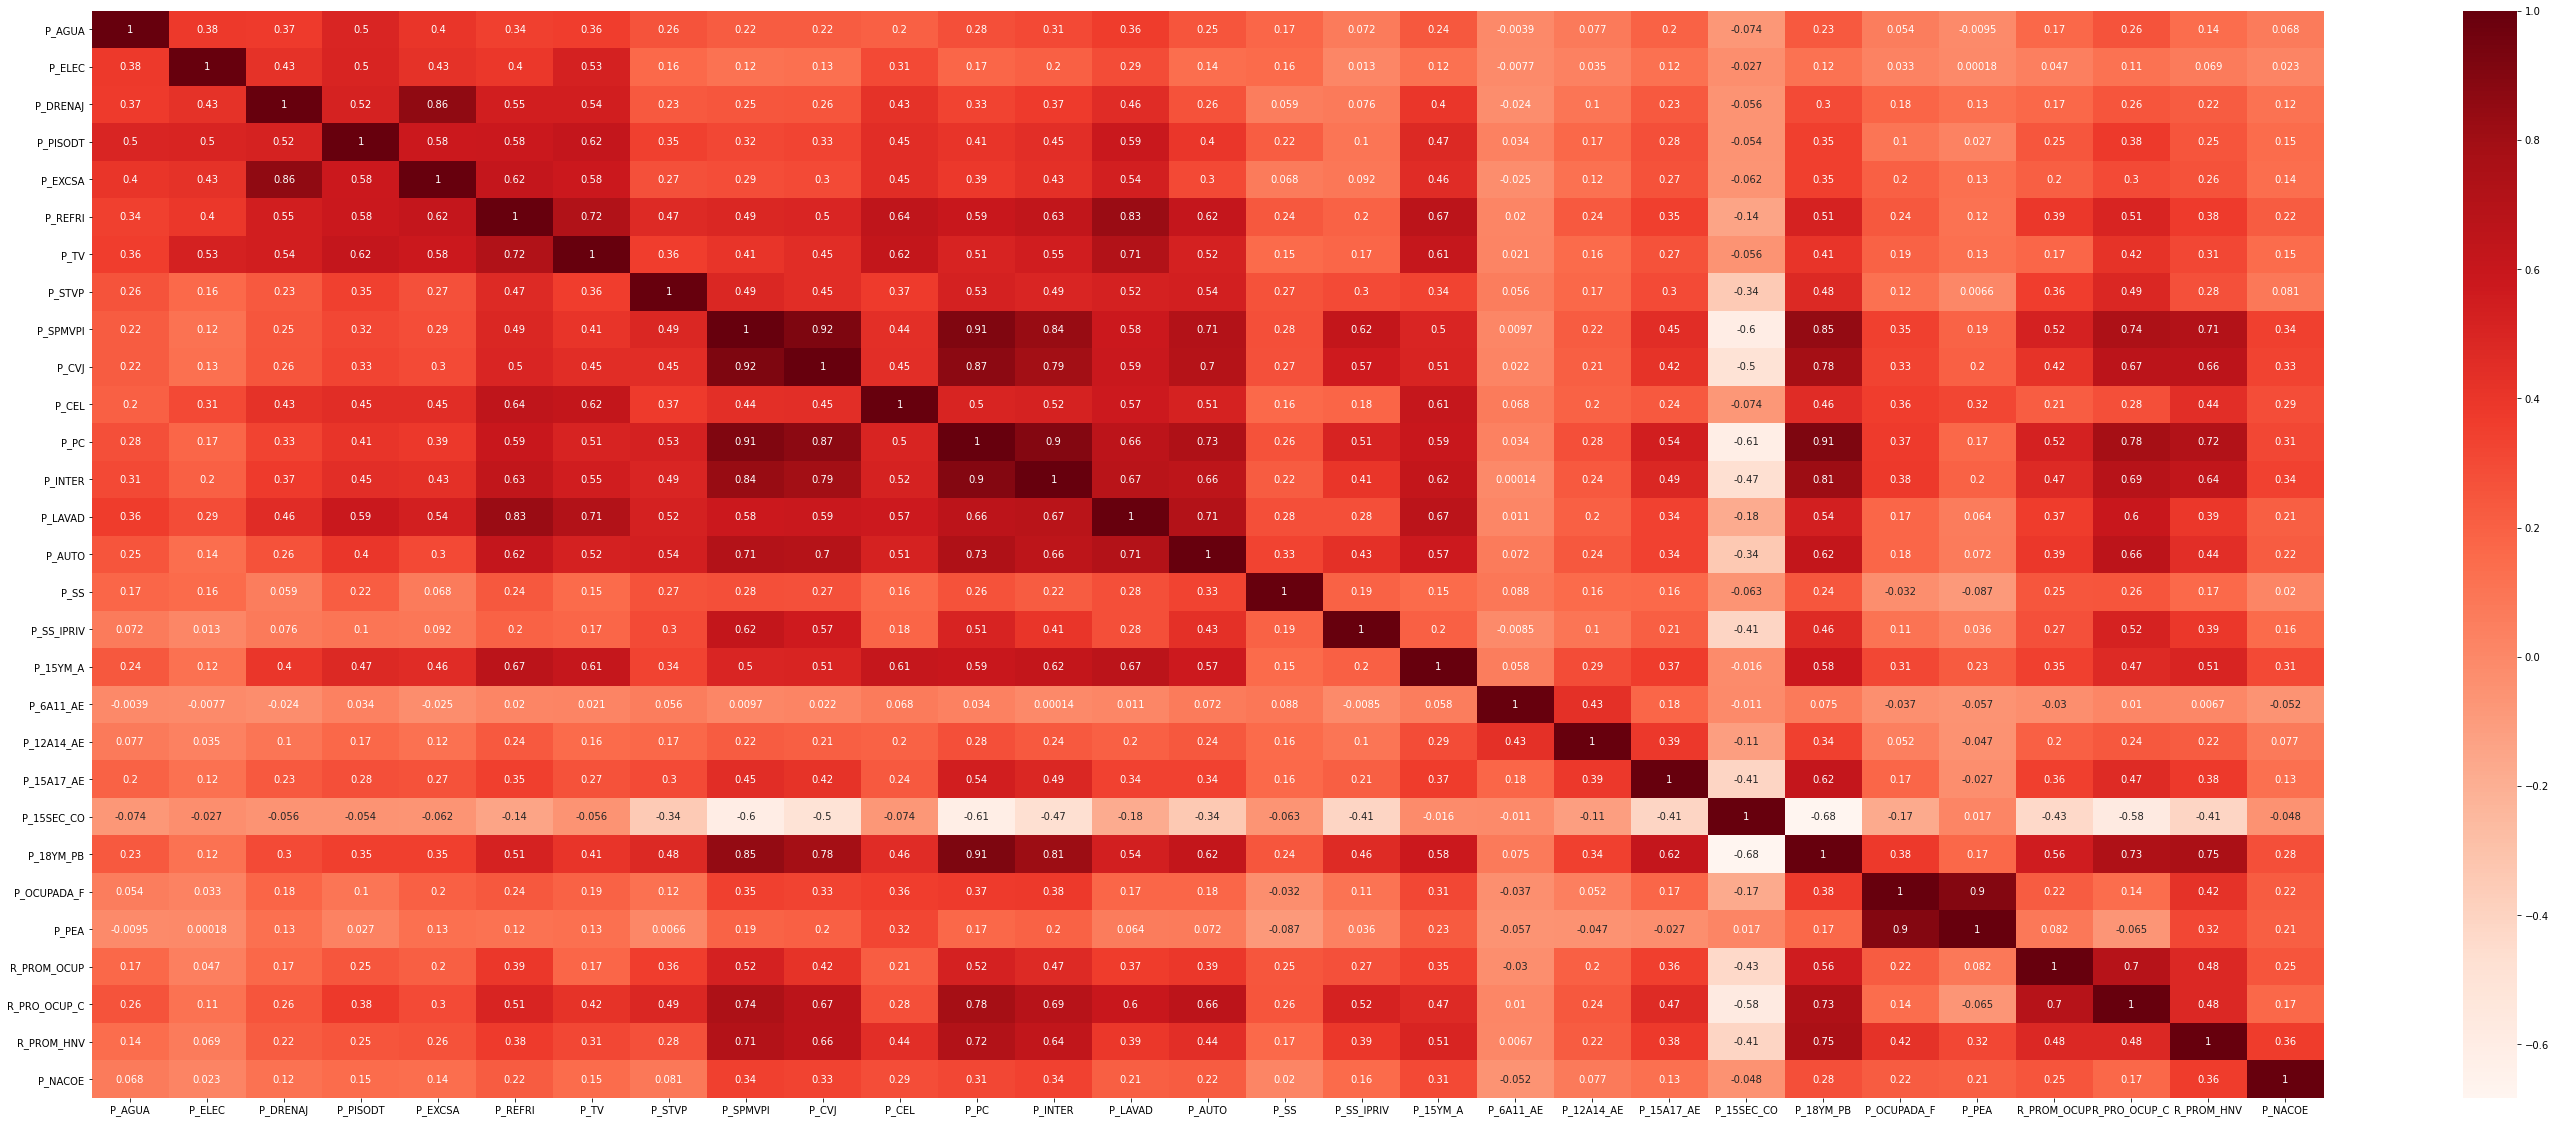

In [12]:
# Using Pearson Correlation
plt.figure(figsize=(50,20))
cor = df_scaled.iloc[:,4:].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
#cor.to_csv("correlation.csv", index= True)
plt.show()

In [13]:
# Look for features with correlation coef > .9
for i in range(cor.shape[0]):
     for j in range(i+1, cor.shape[0]):
            if cor.iloc[i,j] >= 0.9:
                print((cor.index[i], cor.columns[j]))

('P_SPMVPI', 'P_CVJ')
('P_SPMVPI', 'P_PC')
('P_PC', 'P_18YM_PB')


In [14]:
# Drop redundant features
df_scaled.drop(columns=["P_PC", "P_CVJ"], inplace=True)
df_scaled.shape

(51416, 31)

#  Data Visualization

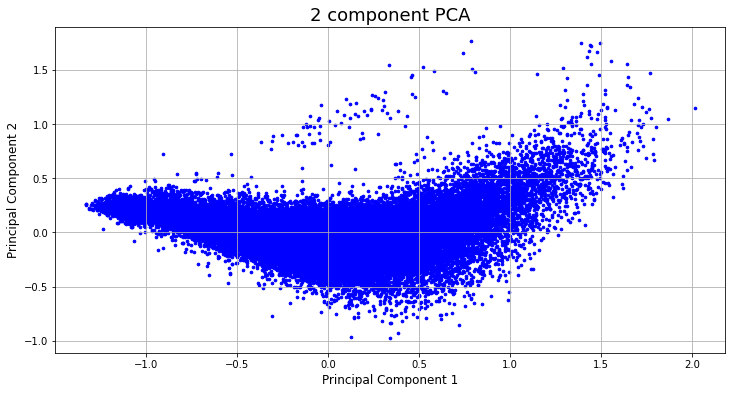

In [16]:
# Perform PCA
pca = PCA(n_components=2,  random_state=0)
pca_2d = pca.fit_transform(df_scaled.iloc[:,4:])

# Scatter plot with the first two principal components
fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize=12)
ax.set_ylabel('Principal Component 2', fontsize=12)
ax.set_title('2 component PCA', fontsize=18)
ax.scatter(pca_2d[:,0], pca_2d[:,1], c='blue', s=7)
ax.grid()
plt.show()

# Outlier Detection

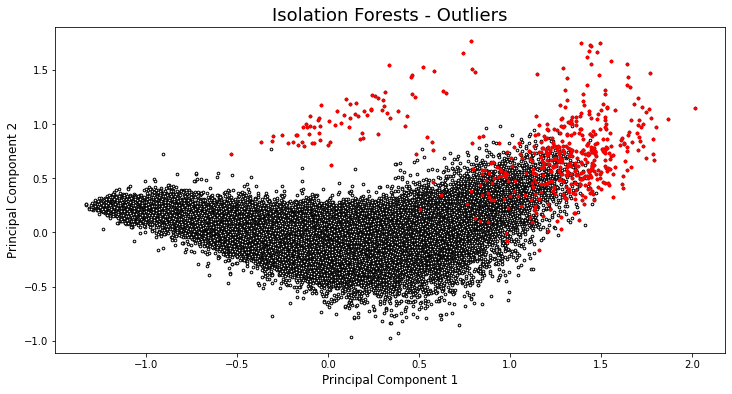

In [17]:
# Outlier detection using Isolation Forest

isof = IsolationForest(max_samples="auto", random_state=0, contamination=.01) 
isof.fit(df_scaled.iloc[:,4:])

if_anomalies = isof.predict(df_scaled.iloc[:,4:])
if_anomalies = pd.Series(if_anomalies).replace([-1,1],[1,0])
if_anomalies = pca_2d[if_anomalies==1]

# Scatter plot with outliers
plt.figure(figsize = (12,6))
plt.scatter(pca_2d[:,0], pca_2d[:,1], c='white', s=7, edgecolor='k')
plt.scatter(if_anomalies[:,0], if_anomalies[:,1], c='red', s=7)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.title('Isolation Forests - Outliers', fontsize=18)
plt.show()

In [18]:
no_anomalies = isof.predict(df_scaled.iloc[:,4:])
df_scaled = df_scaled[no_anomalies==1]
df_scaled.shape

(50901, 31)

# Number of clusters

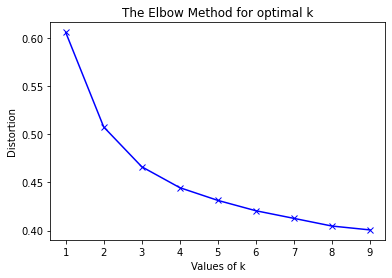

In [19]:
#Elbow Method

X = df_scaled.iloc[:,4:]

from sklearn import metrics
from scipy.spatial.distance import cdist

distortions = []
K = range(1,10)
for k in K:
    kmeans = KMeans(n_clusters=k).fit(X)
    distortions.append(sum(np.min(cdist(X, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of k')
plt.ylabel('Distortion')
plt.title('The Elbow Method for optimal k')
plt.show()

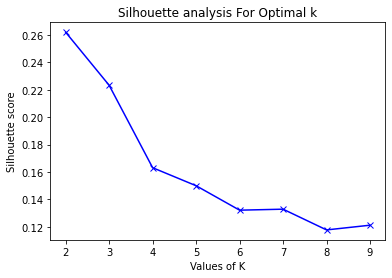

In [20]:

silhouette_avg = []
K = range(2,10)
for k in K:
    # initialise kmeans
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    cluster_labels = kmeans.labels_
    # silhouette score
    silhouette_avg.append(silhouette_score(X, cluster_labels))

# Plot the silhouette
plt.plot(K, silhouette_avg, 'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

We'll use n_clusters=3 so we can have three levels of socioeconomic status (high, middle, and low)

# Clustering

We cluster the data using K Means

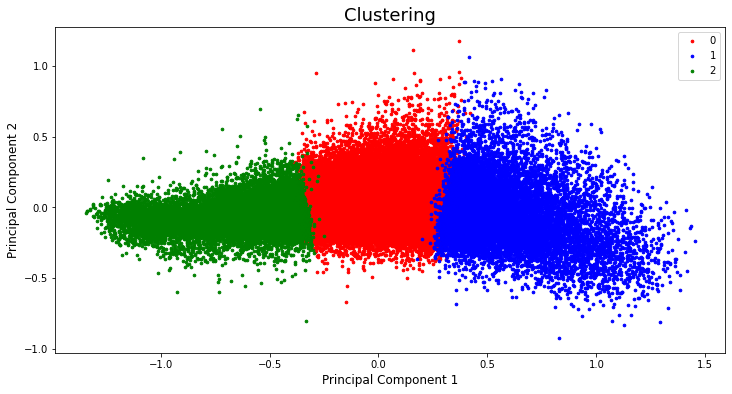

In [21]:
# Using K Means
kmeans = KMeans(n_clusters=3,random_state=0).fit(X)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_.tolist()

pca = PCA(n_components=2)
pca_2d = pca.fit_transform(df_scaled.iloc[:,4:])

# Scatter plot with clusters
clusters = list(set(labels))
num_clusters = len(centroids)
colors = ['red', 'blue', 'green']

fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(1, 1, 1)
targets = pd.DataFrame(data = labels, columns=['target'])
for color, cluster in zip(colors,clusters):
    indicesToKeep = targets['target'] == cluster
    ax.scatter(pca_2d[indicesToKeep,0], 
               pca_2d[indicesToKeep,1], 
               c=color, s=7)
ax.set_xlabel('Principal Component 1', fontsize = 12)
ax.set_ylabel('Principal Component 2', fontsize = 12)
ax.set_title('Clustering', fontsize = 18)
ax.legend(clusters)
plt.show()

In [22]:
df_labeled = df_scaled
df_labeled["label"] = labels

Now we're going to take advantage of our "positive-oriented" features to identify the clusters. We need to compute the distance between each pair of cluster centers, the maximum distance would tell us both the high and low status. To find out which one is the high status, we go to the variables and identify which cluster has the highest values in most of them. 

In [23]:
import itertools
d = {}
counter = 0
for i in centroids :
    d[counter] = i
    counter = counter + 1

dist = []
for i in itertools.combinations(range(3), 2) :
    print("Distance between centers {} and {} is: ".format(i[0], i[1]), np.linalg.norm(d[i[0]]-d[i[1]]))

Distance between centers 0 and 1 is:  0.612871129441709
Distance between centers 0 and 2 is:  0.7053045940950532
Distance between centers 1 and 2 is:  1.2598472982000657


We found that the clusters 1 and 2 have the highest distance between centers. Which cluster represent the high status?

In [24]:
# Mean of each feature for cluster 0
print(df_labeled[df_labeled["label"] == 1].iloc[:,4:].mean())
# Mean of each feature for cluster 1
print(df_labeled[df_labeled["label"] == 2].iloc[:,4:].mean())

P_AGUA          0.907448
P_ELEC          0.983345
P_DRENAJ        0.917833
P_PISODT        0.912470
P_EXCSA         0.891799
P_REFRI         0.757793
P_TV            0.853049
P_STVP          0.305228
P_SPMVPI        0.025448
P_CEL           0.837574
P_INTER         0.222013
P_LAVAD         0.556126
P_AUTO          0.287519
P_SS            0.697718
P_SS_IPRIV      0.005144
P_15YM_A        0.844391
P_6A11_AE       0.962997
P_12A14_AE      0.903408
P_15A17_AE      0.620665
P_15SEC_CO      0.352660
P_18YM_PB       0.271805
P_OCUPADA_F     0.437710
P_PEA           0.603299
R_PROM_OCUP     0.304473
R_PRO_OCUP_C    0.174970
R_PROM_HNV      0.044789
P_NACOE         0.110511
label           1.000000
dtype: float64
P_AGUA          0.997312
P_ELEC          0.998445
P_DRENAJ        0.997707
P_PISODT        0.994585
P_EXCSA         0.997624
P_REFRI         0.982583
P_TV            0.967364
P_STVP          0.618673
P_SPMVPI        0.466149
P_CEL           0.961071
P_INTER         0.834201
P_LAVAD   

Then we can conclude that cluster 2 is the high status and cluster 1 the low status. Therefore cluster 0 is the middle status.

In [26]:
#Order the groups
df_labeled["label"] = df_labeled["label"].replace([2,0,1],[3,2,1])

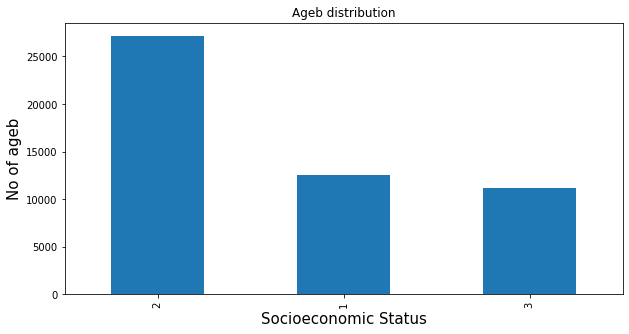

In [27]:
#Frecuency bar chart
df_labeled["label"].value_counts().plot(kind='bar', figsize = (10,5))
plt.xlabel('Socioeconomic Status', fontsize = 15)
plt.ylabel('No of ageb',fontsize = 15)
plt.title('Ageb distribution')
plt.show()

In [28]:
df_labeled[["ENTIDAD", "MUN", "LOC", "AGEB", "label"]].to_csv("ses.csv", index=False)